In [1]:
!pip install ultralytics
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import yaml
from PIL import Image
from collections import deque
from ultralytics import YOLO
from IPython.display import Video

Defaulting to user installation because normal site-packages is not writeable


In [18]:
sns.set(rc={'axes.facecolor': '#ffe4de'}, style='darkgrid')

In [19]:
model = YOLO('yolov8s-seg.pt') 

In [20]:
import yaml

yaml_file_path = 'Pothole_Segmentation_YOLOv8/data.yaml'

with open(yaml_file_path, 'r') as file:
    data = yaml.safe_load(file)

print(data)


{'train': 'train/images', 'val': 'valid/images', 'nc': 1, 'names': ['Pothole'], 'roboflow': {'workspace': 'farzad', 'project': 'pothole_segmentation_yolov8', 'version': 1, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/farzad/pothole_segmentation_yolov8/dataset/1'}}


In [21]:
names=['Pothole']

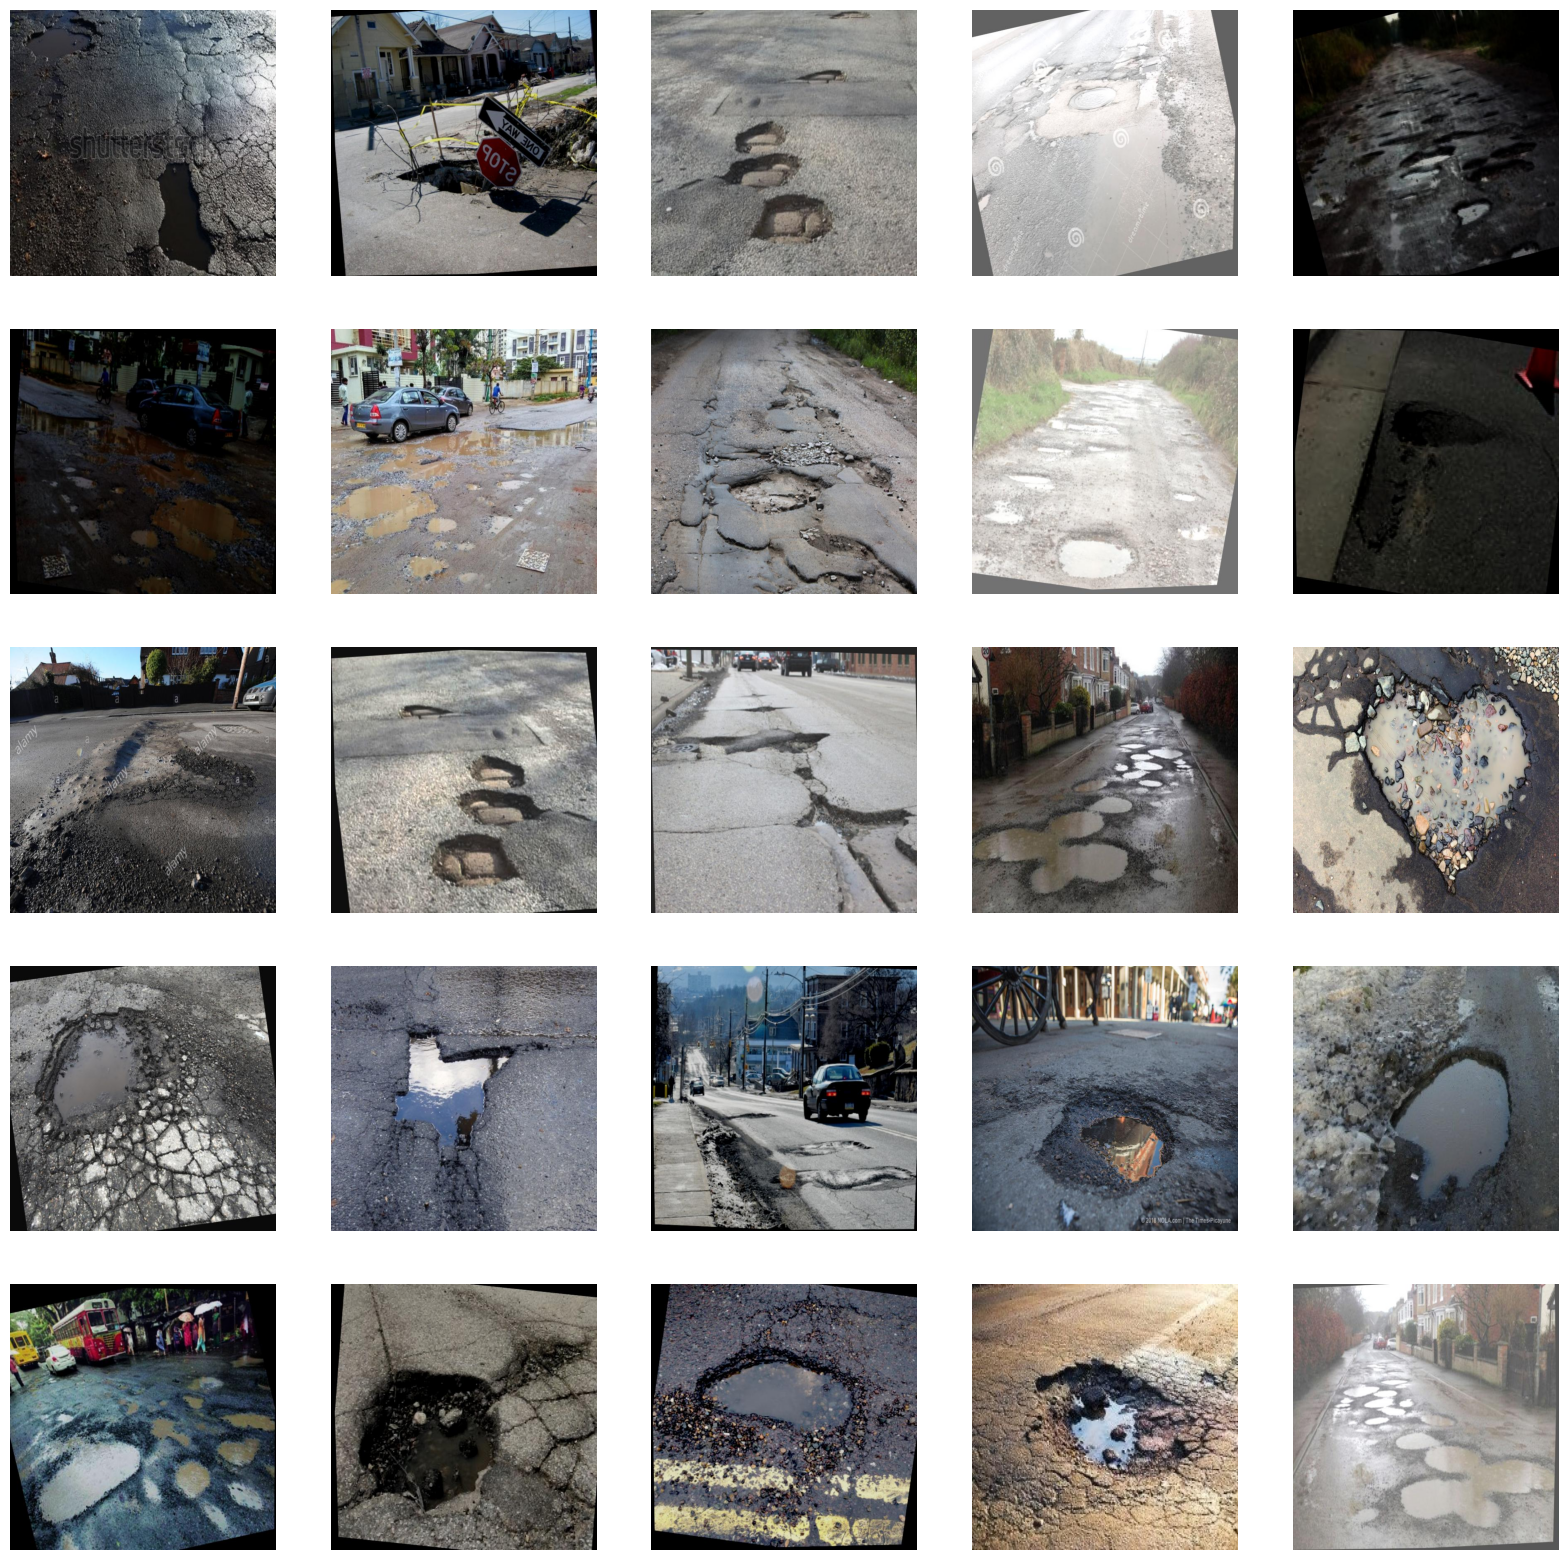

In [22]:
import random 
import cv2
import os
import matplotlib.pyplot as plt

image_dir = 'Pothole_Segmentation_YOLOv8/train/images'
image_files = os.listdir(image_dir)
random_image_file = random.choice(image_files)
img_path = os.path.join(image_dir, random_image_file)

random_images = random.sample(image_files, 25)
label_files = 'Pothole_Segmentation_YOLOv8/train/labels'
fig, axs = plt.subplots(5, 5, figsize=(20,20))

for i, image_file in enumerate(random_images):
    row = i // 5
    col = i % 5
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path)
  
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(label_files, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255,0), 3)
        classe=names[int(class_id)]
        cv2.putText(image, classe, (x_min, y_min -5), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 2, cv2.LINE_AA)


    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

In [23]:
dataset_path='Pothole_Segmentation_YOLOv8'
train_images_path = os.path.join(dataset_path, 'train', 'images')
valid_images_path = os.path.join(dataset_path, 'valid', 'images')

num_train_images = 0
num_valid_images = 0

train_image_sizes = set()
valid_image_sizes = set()

for filename in os.listdir(train_images_path):
    if filename.endswith('.jpg'):  
        num_train_images += 1
        image_path = os.path.join(train_images_path, filename)
        with Image.open(image_path) as img:
            train_image_sizes.add(img.size)

for filename in os.listdir(valid_images_path):
    if filename.endswith('.jpg'):
        num_valid_images+=1
        image_path=os.path.join(valid_images_path,filename)
        with Image.open(image_path) as img:
            valid_image_sizes.add(img.size)


print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_valid_images}")

if len(train_image_sizes) == 1:
    print(f"All training images have the same size: {train_image_sizes.pop()}")
else:
    print("Training images have varying sizes.")

if len(valid_image_sizes) == 1:
    print(f"All validation images have the same size: {valid_image_sizes.pop()}")
else:
    print("Validation images have varying sizes.")

Number of training images: 720
Number of validation images: 60
All training images have the same size: (640, 640)
All validation images have the same size: (640, 640)


In [26]:
results = model.train(
    data=yaml_file_path,    
    epochs=137,             
    imgsz=640,               
    patience=15,             
    batch=16,                
    optimizer='auto',        
    lr0=0.0001,              
    lrf=0.01,                
    dropout=0.25,            
    device='cpu',  # Use CPU since CUDA is not available
    seed=42)

KeyboardInterrupt: 

In [ ]:
from IPython.display import Image,display
import os

results_path = 'runs/segment/train/results.png'
if os.path.exists(results_path):
    display(Image(filename=results_path, width=1000))
else:
    print(f"Results file not found at {results_path}")
    print("Please run the training cell (Cell 7) first to generate the results.")

In [ ]:
best_model_path ='runs/segment/train/weights/best.pt'

if os.path.exists(best_model_path):
    best_model = YOLO(best_model_path)
else:
    raise FileNotFoundError(f"Model file not found at {best_model_path}. Please run the training cell (Cell 7) first.")

metrics = best_model.val(split='val')
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")    
print(f"Mean Average Precision @ .50   : {metrics.box.map50}") 
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")
print("recall : ",metrics.box.r)
print(metrics.box.f1)
print(metrics.box.maps)


In [ ]:
metrics_df = pd.DataFrame.from_dict(metrics.results_dict, orient='index', columns=['Metric Value'])

metrics_df.round(3)

In [ ]:
image_dir = "Pothole_Segmentation_YOLOv8/valid/images"

all_images = os.listdir(image_dir)
selected_images = all_images[:45]

for img_name in selected_images:
    img_path = os.path.join(image_dir, img_name) 
    results = best_model.predict(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    for result in results:
        plotted_img = result.plot()
        plt.figure(figsize=(10,9))  
        plt.imshow(plotted_img)    
        plt.axis('off')             
        plt.show() 

